In [1]:
import os
import sys

#python-data-analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#tensorflow package
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense

#sklearn package
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import StandardScaler

#others
import time
import joblib

#suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
import sys
print(sys.executable)


/home/alaha/miniconda3/envs/al_tfnew/bin/python


In [3]:
#We start by using a small subset
col_names=['Pt0','Pt1','Pt2','NBJet','MET','MaxDphi_LMet','MaxDphi_LL','MinDphi_LL','LLPairPt','Mt0','Mt1','Mt2']
cols = [0,1,2,4,5,13,15,16,20,24,25,26]


In [4]:
WZBk = pd.read_csv('inputs/T3L_2017_WZ_100K.txt',sep=' ',index_col=None, usecols=cols,names=col_names)
WZBk['label']=1

ZZBk = pd.read_csv('inputs/T3L_2017_ZZ_100K.txt',sep=' ',index_col=None, usecols=cols,names=col_names)
ZZBk['label']=0

TTBk = pd.read_csv('inputs/T3L_2017_TTZ_100K.txt',sep=' ',index_col=None, usecols=cols,names=col_names)
TTBk['label']=2

In [5]:
#input variables plot
def plotInputVar(df1,df2,df3,var,mybins,xlabel):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(df1[var],mybins,label='WZ',histtype='step',color='green')
    plt.hist(df2[var],mybins,label='ZZ',histtype='step',color='red')
    plt.hist(df3[var],mybins,label='TTZ',histtype='step',color='blue')
    plt.legend(frameon=False,fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel('Events')
    plt.title('normal scale')

    plt.subplot(1,2,2)
    plt.hist(df1[var],mybins,label='WZ',histtype='step',color='green')
    plt.hist(df2[var],mybins,label='ZZ',histtype='step',color='red')
    plt.hist(df3[var],mybins,label='TTZ',histtype='step',color='blue')
    plt.legend(frameon=False,fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel('Events')
    plt.title('log scale')
    plt.semilogy()

## plot after scaling
def plotScaledVar(X_array,y_array,col_pos,mybins,xlabel):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(X_array[np.argmax(y_array,axis=1)==0][:,col_pos],bins=mybins,histtype='step',color="red",label='ZZ',density=True)
    plt.hist(X_array[np.argmax(y_array,axis=1)==1][:,col_pos],bins=mybins,histtype='step',color="green",label='WZ',density=True)
    plt.hist(X_array[np.argmax(y_array,axis=1)==2][:,col_pos],bins=mybins,histtype='step',color="blue",label='TTZ',density=True)
    plt.legend(frameon=False,fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel('Events')
    plt.title('normal scale')

    plt.subplot(1,2,2)
    plt.hist(X_array[np.argmax(y_array,axis=1)==0][:,col_pos],bins=mybins,histtype='step',color="red",label='ZZ',density=True)
    plt.hist(X_array[np.argmax(y_array,axis=1)==1][:,col_pos],bins=mybins,histtype='step',color="green",label='WZ',density=True)
    plt.hist(X_array[np.argmax(y_array,axis=1)==2][:,col_pos],bins=mybins,histtype='step',color="blue",label='TTZ',density=True)
    plt.legend(frameon=False,fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel('Events')
    plt.title('log scale')
    plt.semilogy()


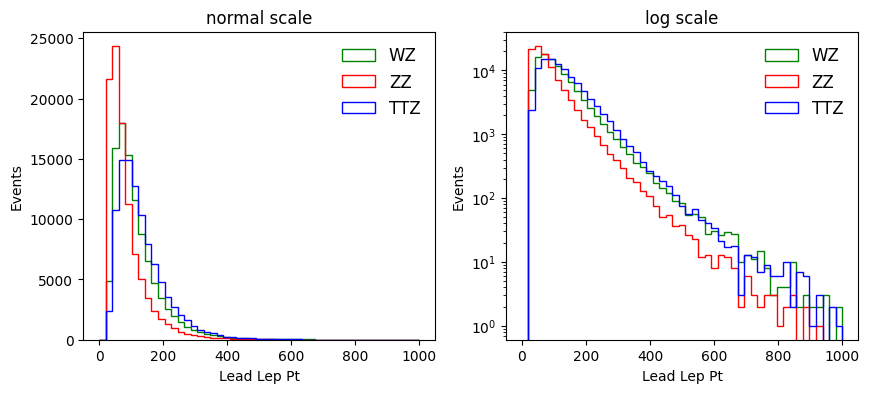

In [6]:
plotInputVar(WZBk,ZZBk,TTBk,"Pt0",np.linspace(0,1000,50),"Lead Lep Pt")

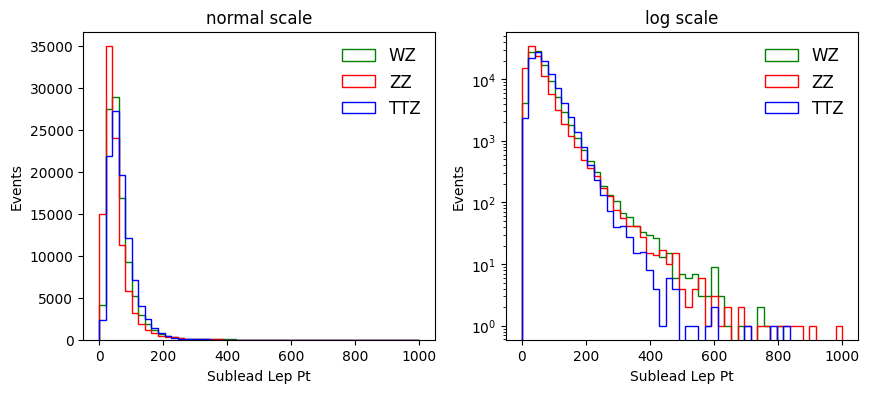

In [7]:
plotInputVar(WZBk,ZZBk,TTBk,"Pt1",np.linspace(0,1000,50),"Sublead Lep Pt")

### Combined dataframe

In [8]:
data = pd.concat([WZBk,ZZBk,TTBk])
X, y = data.values[:,:-1], data.values[:,-1]
#Here the y values, or labels are turned from 0,1,2 into
# one hot encoded values (1,0,0),(0,1,0),(0,0,1)
ohe_y = tf.keras.utils.to_categorical(y)

### Train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,ohe_y,test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
n_features = X_train.shape[1]
print(f'The number of input variables is {n_features}')

(240000, 12) (60000, 12) (240000, 3) (60000, 3)
The number of input variables is 12


### X-range scaling (normalization)

In [10]:
##Normalize the input
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
print("Training statistics\n")
print("Train WZ shape : ",X_train[np.argmax(y_train,axis=1)==0].shape)
print("Train ZZ shape : ",X_train[np.argmax(y_train,axis=1)==1].shape)
print("Train TTZ shape: ",X_train[np.argmax(y_train,axis=1)==2].shape)
print()
print("Testing statistics\n")
print("Test WZ shape : ",X_test[np.argmax(y_test,axis=1)==0].shape)
print("Test ZZ shape : ",X_test[np.argmax(y_test,axis=1)==1].shape)
print("Test TTZ shape: ",X_test[np.argmax(y_test,axis=1)==2].shape)


Training statistics

Train WZ shape :  (80002, 12)
Train ZZ shape :  (80138, 12)
Train TTZ shape:  (79860, 12)

Testing statistics

Test WZ shape :  (19998, 12)
Test ZZ shape :  (19862, 12)
Test TTZ shape:  (20140, 12)


### How does the X_input looks like after and before scaling

Input shape before scaling


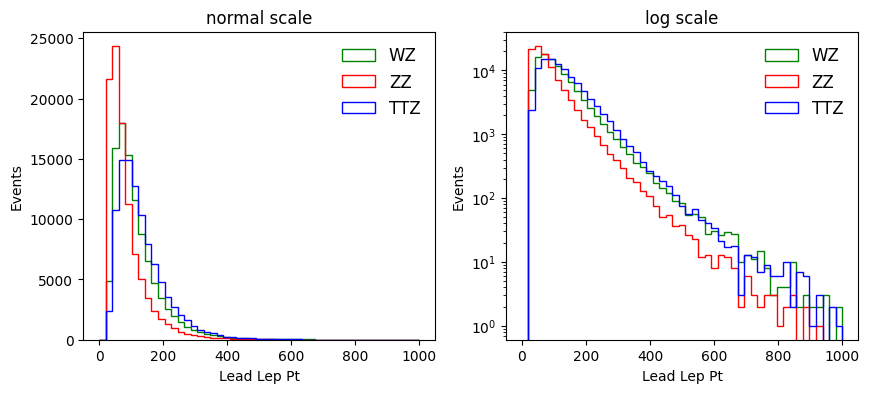

In [12]:
print("Input shape before scaling")
plotInputVar(WZBk,ZZBk,TTBk,"Pt0",np.linspace(0,1000,50),"Lead Lep Pt");

Input shape after scaling


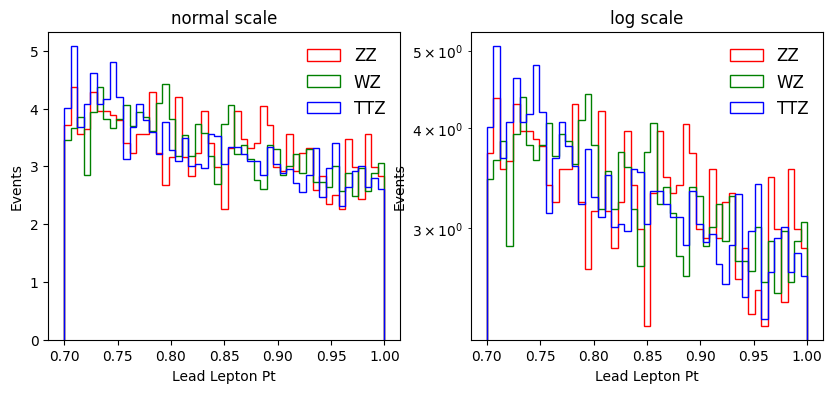

In [55]:
print("Input shape after scaling")
plotScaledVar(X_train,y_train,col_pos=0,mybins=np.linspace(0.7,1,50),xlabel="Lead Lepton Pt")

## Model architecture

In [14]:
modelfiledir='modeldata/'
modelname=f'multiclass'

epoch = 50
batchsize=1024


In [15]:
#define callbacks. Here the model with highest accuracy will be saved at end...
cb = [ModelCheckpoint(filepath=f"{modelfiledir}/best_model_{modelname}.h5",monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]
"""
Model Architecture
"""
model = Sequential()
model.add(Dense(256, activation='relu', kernel_initializer='he_normal', input_dim=n_features))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(3, activation='softmax'))


### compile the model and train

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train, epochs=epoch, batch_size=batchsize,validation_data=(X_test, y_test), verbose=1,callbacks=cb)
model.summary()
model.save(f'{modelfiledir}/{modelname}.h5')
joblib.dump(scaler,f'{modelfiledir}/scaler_{modelname}.save')


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6973 - loss: 0.6859
Epoch 1: val_accuracy improved from -inf to 0.74527, saving model to modeldata//best_model_multiclass.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6975 - loss: 0.6856 - val_accuracy: 0.7453 - val_loss: 0.5912
Epoch 2/50
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7442 - loss: 0.5916
Epoch 2: val_accuracy improved from 0.74527 to 0.74682, saving model to modeldata//best_model_multiclass.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7443 - loss: 0.5916 - val_accuracy: 0.7468 - val_loss: 0.5844
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7495 - loss: 0.5831
Epoch 3: val_accuracy improved from 0.74682 to 0.75043, saving model to modeldata//best_model_multiclass.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7495 - loss: 0.5831 - val_accuracy: 0.7504 - val_loss: 0.5806
Epoch 4/50
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7486 - loss: 0.5804
Epoch 4: val_accuracy did not improve from 0.75043
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7486 - loss: 0.5804 - val_accuracy: 0.7502 - val_loss: 0.5791
Epoch 5/50
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7494 - loss: 0.5781
Epoch 5: val_accuracy improved from 0.75043 to 0.75090, saving model to modeldata//best_model_multiclass.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7494 - loss: 0.5781 - val_accuracy: 0.7509 - val_loss: 0.5786
Epoch 6/50
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7508 - loss: 0.5760
Epoch 6: val_accuracy did not improve from 0.75090
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7508 - loss: 0.5760 - val_accuracy: 0.7502 - val_loss: 0.5773
Epoch 7/50
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7520 - loss: 0.5731
Epoch 7: val_accuracy did not improve from 0.75090
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7520 - loss: 0.5731 - val_accuracy: 0.7499 - val_loss: 0.5776
Epoch 8/50
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7510 - loss: 0.5748
Epoch 8: val_accuracy did not improve from 0.75090
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7510 - loss: 0.5748 - val_accuracy: 0.7505 - val_loss: 0.5769
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7524 - loss: 0.5708
Epoch 9: val_accuracy improved f

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7524 - loss: 0.5708 - val_accuracy: 0.7514 - val_loss: 0.5753
Epoch 10/50
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7509 - loss: 0.5725
Epoch 10: val_accuracy improved from 0.75138 to 0.75170, saving model to modeldata//best_model_multiclass.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7509 - loss: 0.5724 - val_accuracy: 0.7517 - val_loss: 0.5746
Epoch 11/50
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7516 - loss: 0.5708
Epoch 11: val_accuracy improved from 0.75170 to 0.75175, saving model to modeldata//best_model_multiclass.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7516 - loss: 0.5708 - val_accuracy: 0.7517 - val_loss: 0.5746
Epoch 12/50
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7524 - loss: 0.5689
Epoch 12: val_accuracy did not improve from 0.75175
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7524 - loss: 0.5689 - val_accuracy: 0.7516 - val_loss: 0.5745
Epoch 13/50
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7526 - loss: 0.5696
Epoch 13: val_accuracy improved from 0.75175 to 0.75193, saving model to modeldata//best_model_multiclass.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7526 - loss: 0.5695 - val_accuracy: 0.7519 - val_loss: 0.5740
Epoch 14/50
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7535 - loss: 0.5666
Epoch 14: val_accuracy did not improve from 0.75193
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7534 - loss: 0.5666 - val_accuracy: 0.7517 - val_loss: 0.5756
Epoch 15/50
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7553 - loss: 0.5638
Epoch 15: val_accuracy did not improve from 0.75193
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7552 - loss: 0.5639 - val_accuracy: 0.7508 - val_loss: 0.5763
Epoch 16/50
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7545 - loss: 0.5643
Epoch 16: val_accuracy did not improve from 0.75193
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7545 - loss: 0.5643 - val_accuracy: 0.7511 - val_loss: 0.5750
Epoch 17/50
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7538 - loss: 0.5633
Epoch 17: val_accuracy d

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7563 - loss: 0.5591 - val_accuracy: 0.7524 - val_loss: 0.5735
Epoch 22/50
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7568 - loss: 0.5568
Epoch 22: val_accuracy did not improve from 0.75238
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7568 - loss: 0.5569 - val_accuracy: 0.7517 - val_loss: 0.5747
Epoch 23/50
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7568 - loss: 0.5551
Epoch 23: val_accuracy improved from 0.75238 to 0.75308, saving model to modeldata//best_model_multiclass.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7567 - loss: 0.5552 - val_accuracy: 0.7531 - val_loss: 0.5729
Epoch 24/50
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7561 - loss: 0.5567
Epoch 24: val_accuracy did not improve from 0.75308
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7560 - loss: 0.5567 - val_accuracy: 0.7501 - val_loss: 0.5787
Epoch 25/50
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7547 - loss: 0.5584
Epoch 25: val_accuracy did not improve from 0.75308
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7547 - loss: 0.5584 - val_accuracy: 0.7523 - val_loss: 0.5744
Epoch 26/50
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7561 - loss: 0.5556
Epoch 26: val_accuracy did not improve from 0.75308
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7560 - loss: 0.5557 - val_accuracy: 0.7505 - val_loss: 0.5745
Epoch 27/50
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7581 - loss: 0.5539
Epoch 27: val_accura

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,419 (552.42 KB)

 Trainable params: 47,139 (184.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 94,280 (368.29 KB)

['modeldata//scaler_multiclass.save']

In [17]:
!ls modeldata/

best_model_multiclass.h5  multiclass.h5  scaler_multiclass.save


### Loss and Accuracy plots

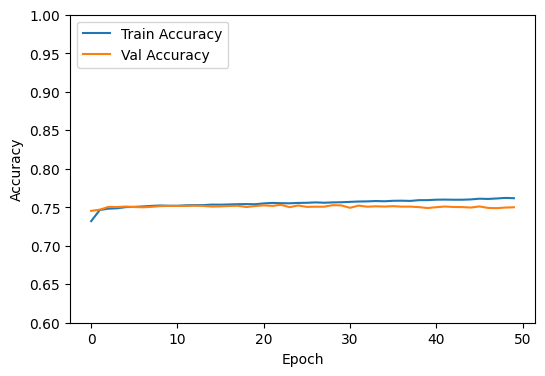

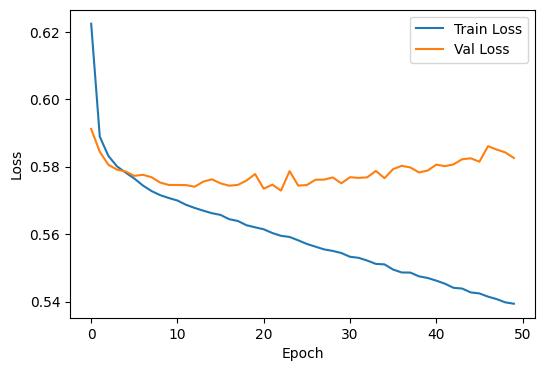

In [29]:
# Thats it. Now the rest of this file is just making various plots

# Let us start by making plots of the accuracy and loss as a function of epochs
# this tells us how the training went.

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1])
plt.legend(loc='upper left')
#plt.semilogy()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.001, 10])
#plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

In [19]:
#scores at each output neuron
# ZZ, WZ, TTZ

In [20]:
nnscore = model.predict(X_test,batch_size=10000)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [21]:
nnscore

array([[6.1253837e-04, 4.6517521e-02, 9.5287001e-01],
       [7.4057287e-04, 8.4371138e-03, 9.9082226e-01],
       [5.3069770e-01, 4.6286407e-01, 6.4381794e-03],
       ...,
       [2.1558236e-01, 7.4802846e-01, 3.6389232e-02],
       [4.0405630e-03, 1.8381037e-01, 8.1214905e-01],
       [7.9718870e-01, 1.8706048e-01, 1.5750719e-02]], dtype=float32)

### Score the plot at each output neuron

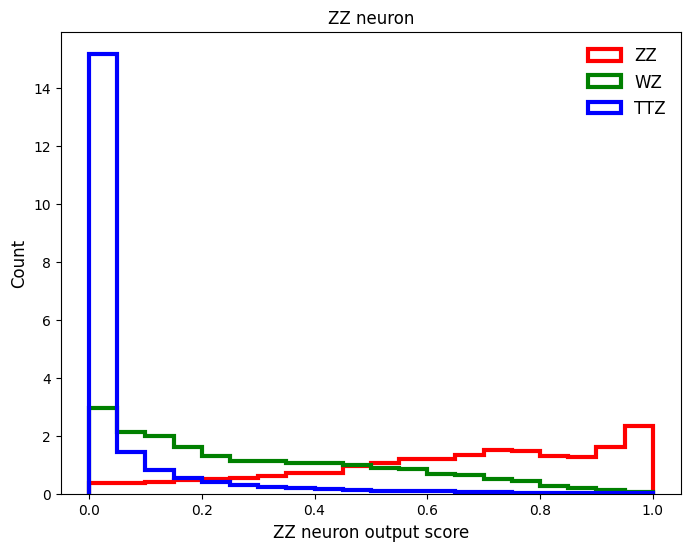

In [51]:
plt.figure(figsize=(8,6))
plt.hist(nnscore[np.argmax(y_test,axis=1)==0][:,0],bins=np.arange(0,1.05,0.05),histtype='step',color="red",lw=3,label='ZZ',density=True)
plt.hist(nnscore[np.argmax(y_test,axis=1)==1][:,0],bins=np.arange(0,1.05,0.05),histtype='step',color="green",lw=3,label='WZ',density=True)
plt.hist(nnscore[np.argmax(y_test,axis=1)==2][:,0],bins=np.arange(0,1.05,0.05),histtype='step',color="blue",lw=3,label='TTZ',density=True)
plt.xlabel("ZZ neuron output score",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.title("ZZ neuron")
plt.legend(frameon=False,fontsize=12)
plt.show()

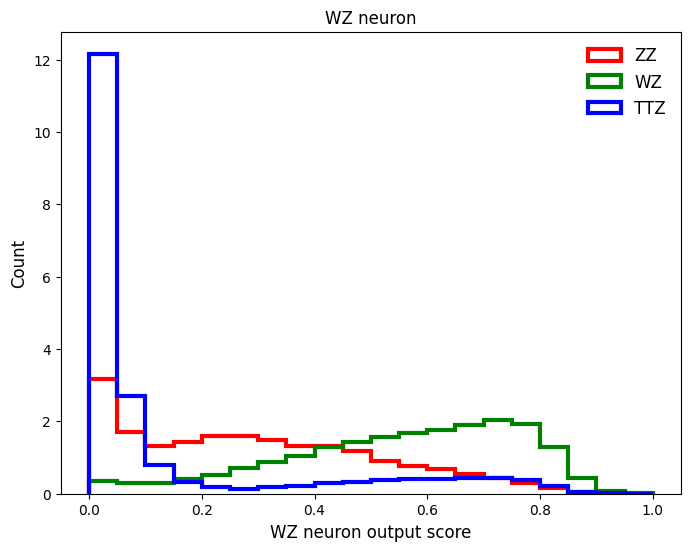

In [52]:
plt.figure(figsize=(8,6))
plt.hist(nnscore[np.argmax(y_test,axis=1)==0][:,1],bins=np.arange(0,1.05,0.05),histtype='step',color="red",lw=3,label='ZZ',density=True)
plt.hist(nnscore[np.argmax(y_test,axis=1)==1][:,1],bins=np.arange(0,1.05,0.05),histtype='step',color="green",lw=3,label='WZ',density=True)
plt.hist(nnscore[np.argmax(y_test,axis=1)==2][:,1],bins=np.arange(0,1.05,0.05),histtype='step',color="blue",lw=3,label='TTZ',density=True)
plt.xlabel("WZ neuron output score",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.title("WZ neuron")
plt.legend(frameon=False,fontsize=12)
plt.show()

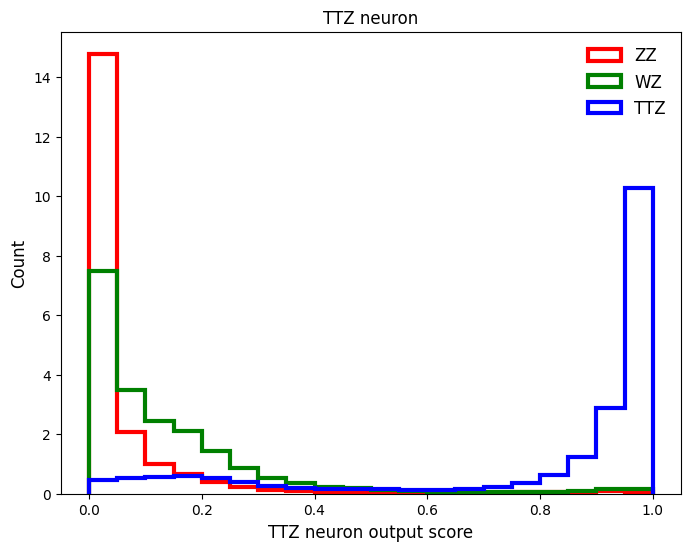

In [54]:
plt.figure(figsize=(8,6))
plt.hist(nnscore[np.argmax(y_test,axis=1)==0][:,2],bins=np.arange(0,1.05,0.05),histtype='step',color="red",lw=3,label='ZZ',density=True)
plt.hist(nnscore[np.argmax(y_test,axis=1)==1][:,2],bins=np.arange(0,1.05,0.05),histtype='step',color="green",lw=3,label='WZ',density=True)
plt.hist(nnscore[np.argmax(y_test,axis=1)==2][:,2],bins=np.arange(0,1.05,0.05),histtype='step',color="blue",lw=3,label='TTZ',density=True)
plt.xlabel("TTZ neuron output score",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.title("TTZ neuron")
plt.legend(frameon=False,fontsize=12)
plt.show()